# Misinformation Detection
### Data Visualisation Notebook

*Session 20 Group 4*
*Erica, Sahan, Dinuka*


Imports:

In [4]:
import pandas as pd
import os
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np

Reading in data:

In [9]:
dataset = pd.read_csv("data/processed_dataset.csv", index_col=0)

dataset.head()

,text,label
0,the reason why jade helm is obama favorite con...,fake
1,us president donald trump revised hardline pol...,real
2,brazilian congressional report recommended on ...,real
3,ah the simpsons the hilarious animated show th...,fake
4,says former fbi director james comey admitted ...,fake


Visualise with a wordcloud

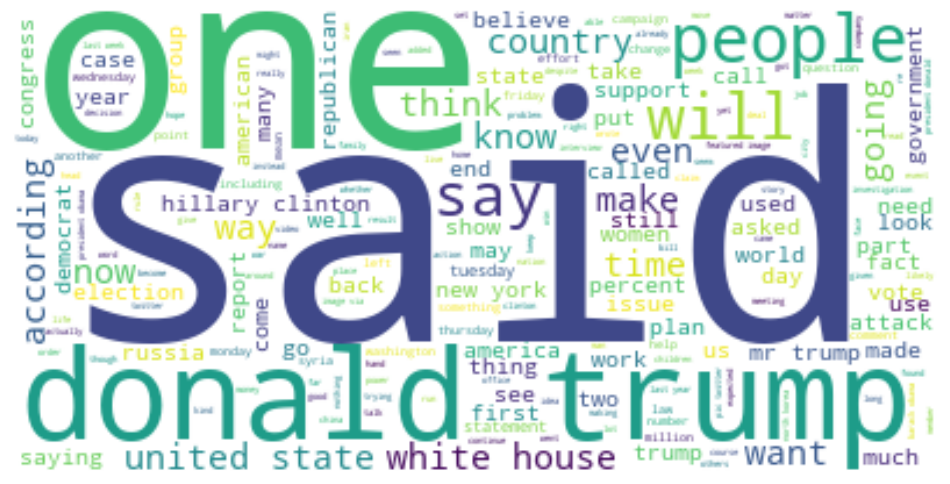

In [10]:
# Generate a wordcloud
text = " ".join(content for content in dataset.text)
wordcloud = WordCloud(background_color="white").generate(text)

# Display it
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We should consider removing stopwords. We can remove these by applying a stopwords filter. There is one supplied by the wordclouds library.

The default filter here does not include "said", but this is a reasonable addition to the stopwords filter for this use case. 
We are not going to analyse who said what or anything, and will be making predictions on this dataset based purely off of word frequencies and/or semantic embeddings. Neither of these will care much about the word "said".

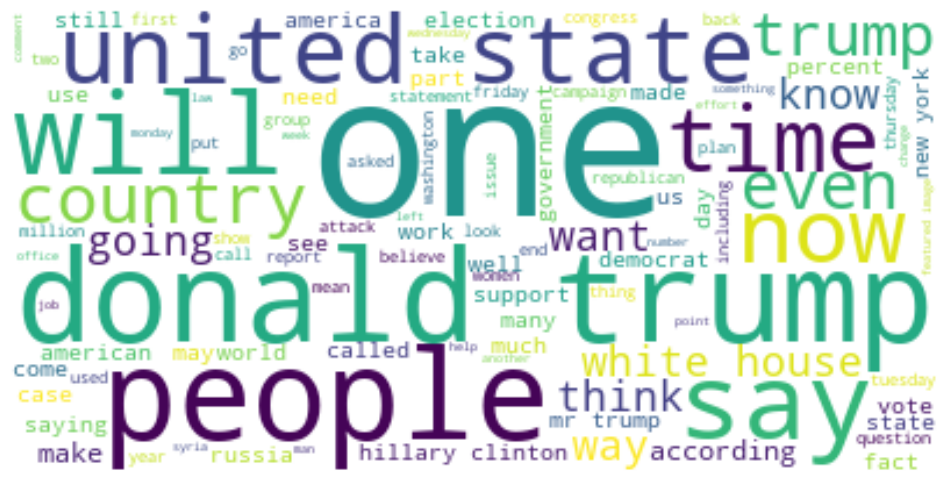

In [12]:
stopwords = set(STOPWORDS)
stopwords.update(["said"])

wordcloud = WordCloud(background_color="white", stopwords=stopwords).generate(text)

# Display our Word Cloud
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Viewing some statistics about the data

6.4
4.8


<Axes: ylabel='count'>

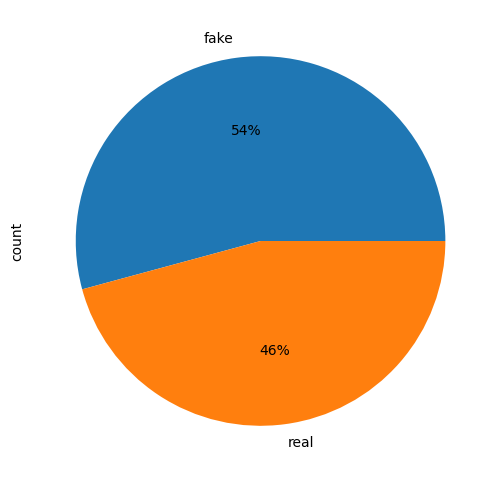

In [13]:
# Plot pie chart showing the split beyween real and fake
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size

dataset.label.value_counts().plot(kind='pie', autopct='%1.0f%%')

Slight weighting towards fake posts. Possibly worth considering a weighted loss function.